#2.Identify Car-Following Pairs

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn

file_path = 'D:/ASU Academics/Traffic Flow Theroy/MP-1/Reconstructed NGSIM I80-1 data/Data/DATA (NO MOTORCYCLES).txt'

columns = [
    "Vehicle ID",
    "Frame ID",
    "Lane ID",
    "LocalY",
    "Mean Speed",
    "Mean Acceleration",
    "Vehicle Length",
    "Vehicle Class ID",
    "Follower ID",
    "Leader ID"
]
df = pd.read_csv(file_path, sep='\t', header=None, names=columns)

df = df[df["Follower ID"] != -1]  # -1 represents no follower.
grouped = df.groupby(["Vehicle ID", "Follower ID"])

valid_pairs = []

for (vehicle_id, follower_id), group in grouped:
    group = group.sort_values(by="Frame ID")
    frame_diff = group["Frame ID"].diff().fillna(0)  # Difference between consecutive frames
    continuous = frame_diff <= 1  # True if frames are continuous (0.1-s steps)

    continuous_segment = (continuous != continuous.shift()).cumsum()
    continuous_lengths = continuous.groupby(continuous_segment).sum()

    if (continuous_lengths >= 200).any():  # (from: On the assessment of vehicle trajectory data accuracy and application to the Next Generation SIMulation (NGSIM) program data)
        valid_pairs.append((vehicle_id, follower_id))

print(f"Number of valid car-following pairs: {len(valid_pairs)}")

Number of valid car-following pairs: 2019


#3.Visualize Car-Following Pairs

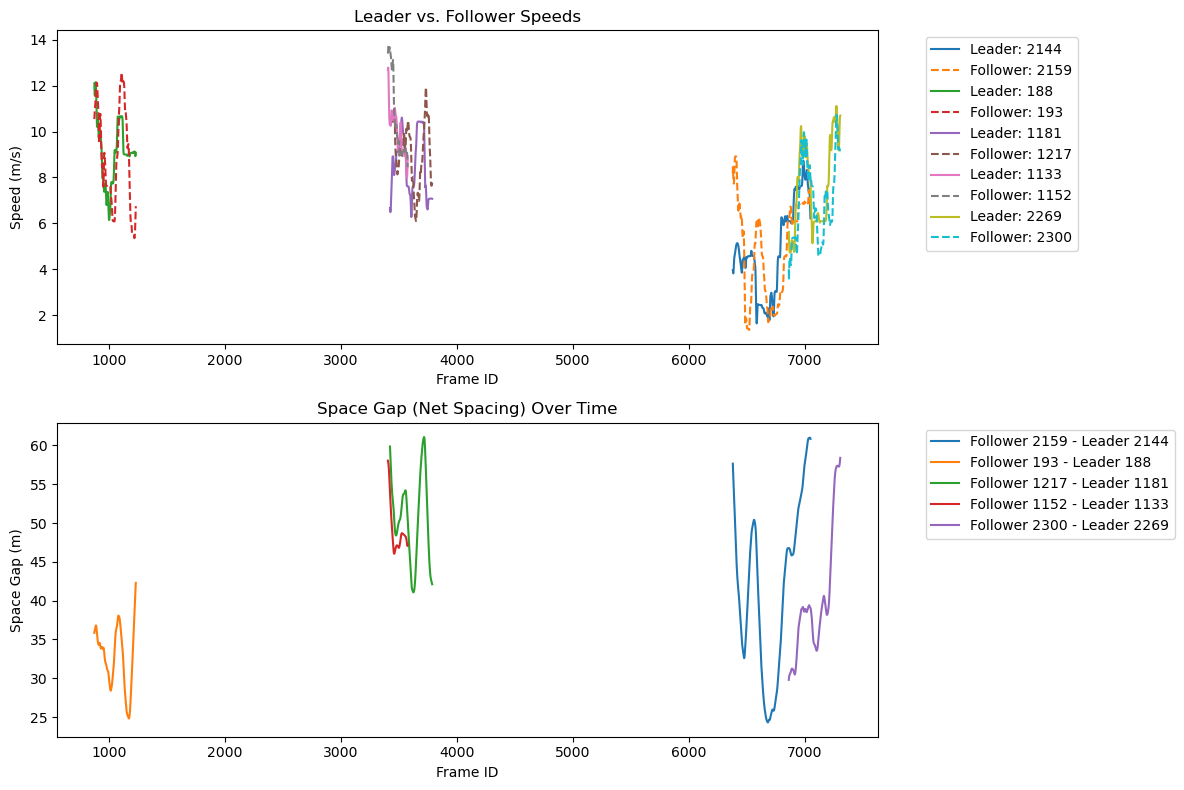

In [4]:
df = pd.read_csv(file_path, sep='\t', header=None, names=columns)

# Filter out non-following vehicles
df = df[df["Leader ID"] != -1]  # Exclude vehicles without a leader

# Assuming data has a fixed frame rate (e.g., 10 FPS, so 20s = 200 frames)
FRAME_THRESHOLD = 200  # Adjust based on actual frame rate

# Group by (Leader, Follower) to analyze interactions
grouped = df.groupby(["Leader ID", "Follower ID"])

# Identify valid car-following pairs
valid_pairs = []
for (leader_id, follower_id), group in grouped:
    duration = group["Frame ID"].nunique()  # Count unique frames
    if duration >= FRAME_THRESHOLD:
        valid_pairs.append((leader_id, follower_id))

# Randomly select 5 valid pairs for visualization
selected_pairs = pd.DataFrame(valid_pairs, columns=["Leader ID", "Follower ID"]).sample(n=5, random_state=42)

# Plot the speed and space gaps
plt.figure(figsize=(12, 8))

for index, row in selected_pairs.iterrows():
    leader_id = row["Leader ID"]
    follower_id = row["Follower ID"]

    leader_data = df[df["Vehicle ID"] == leader_id]
    follower_data = df[df["Vehicle ID"] == follower_id]

    # Ensure timestamps align
    merged = pd.merge(follower_data, leader_data, on="Frame ID", suffixes=("_follower", "_leader"))

    # Compute space gap
    merged["Space Gap"] = merged["LocalY_leader"] - merged["LocalY_follower"]

    # Plot speeds
    plt.subplot(2, 1, 1)
    plt.plot(merged["Frame ID"], merged["Mean Speed_leader"], label=f"Leader: {leader_id}")
    plt.plot(merged["Frame ID"], merged["Mean Speed_follower"], label=f"Follower: {follower_id}", linestyle="dashed")

    # Plot space gap
    plt.subplot(2, 1, 2)
    plt.plot(merged["Frame ID"], merged["Space Gap"], label=f"Follower {follower_id} - Leader {leader_id}")

plt.subplot(2, 1, 1)
plt.title("Leader vs. Follower Speeds")
plt.xlabel("Frame ID")
plt.ylabel("Speed (m/s)")
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1))

plt.subplot(2, 1, 2)
plt.title("Space Gap (Net Spacing) Over Time")
plt.xlabel("Frame ID")
plt.ylabel("Space Gap (m)")
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

#4.

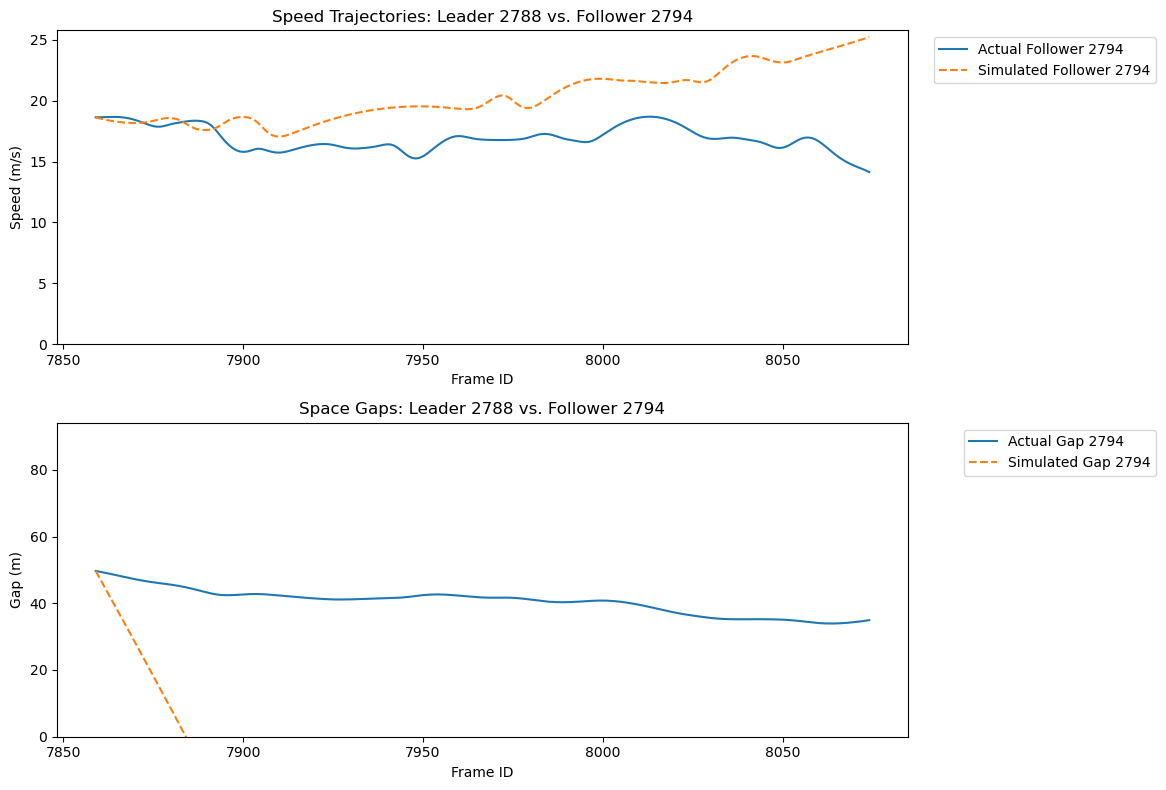

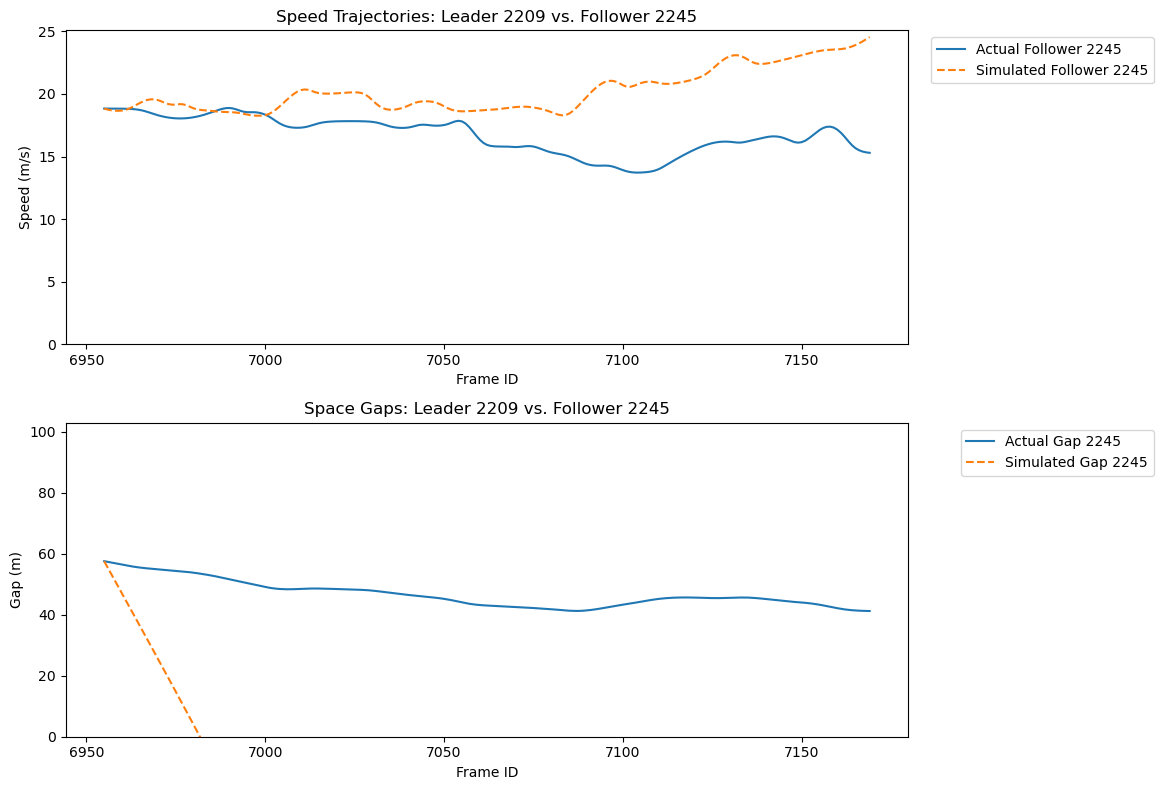

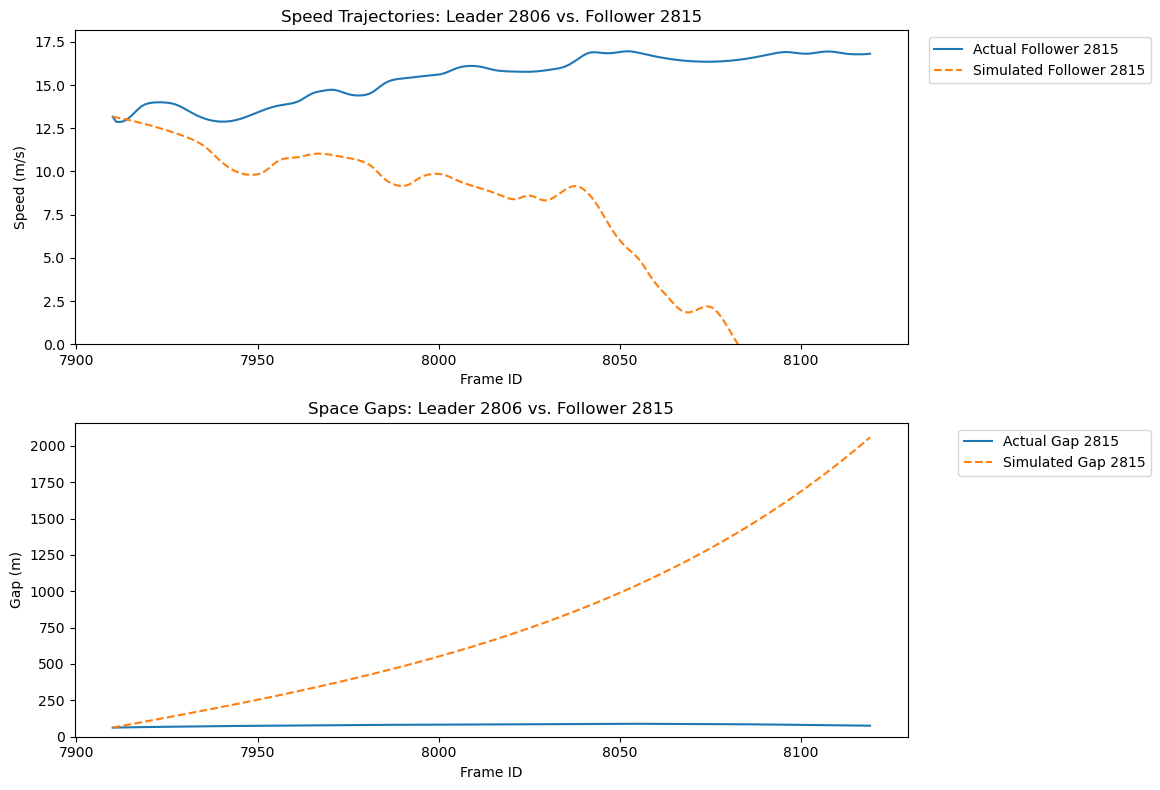

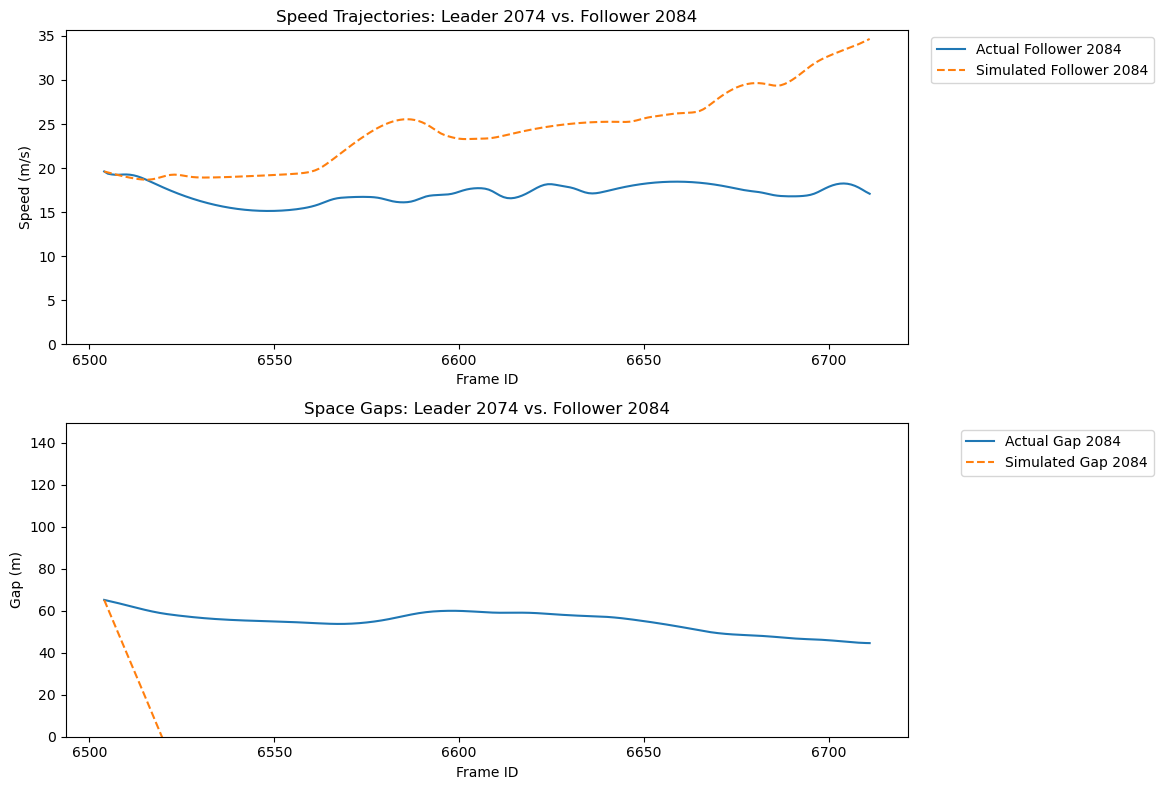

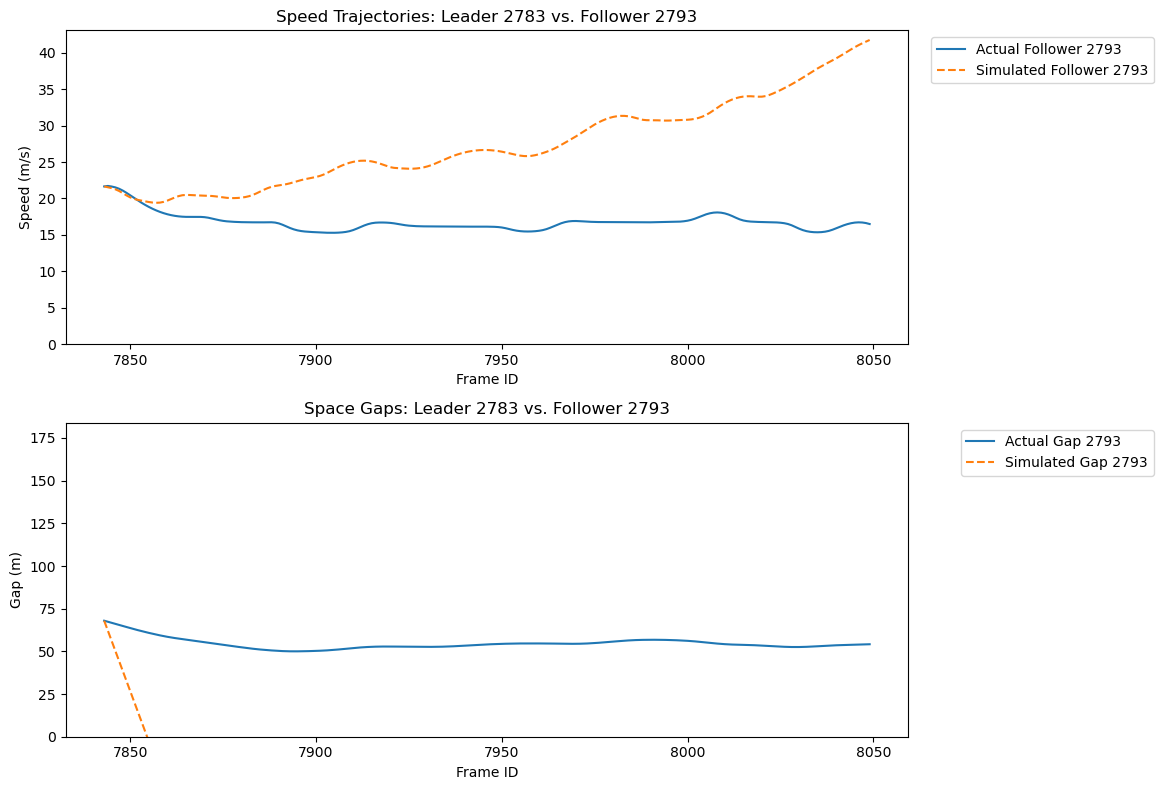

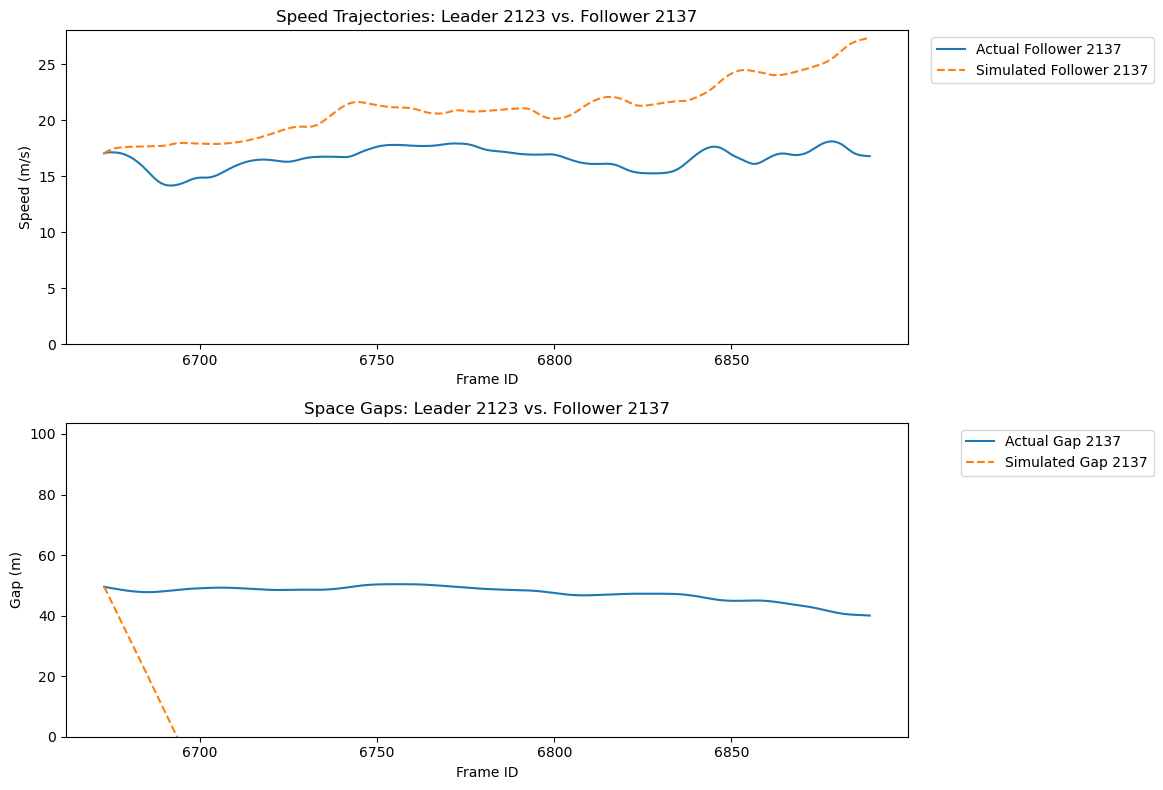

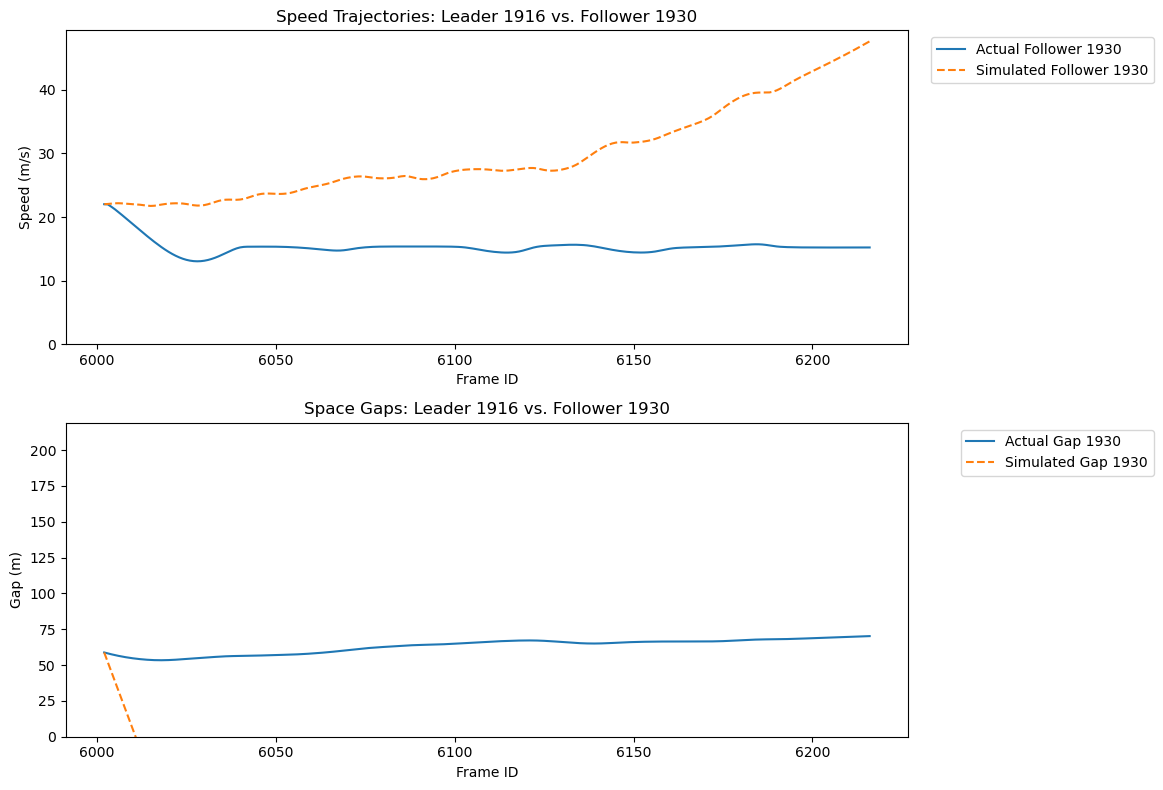

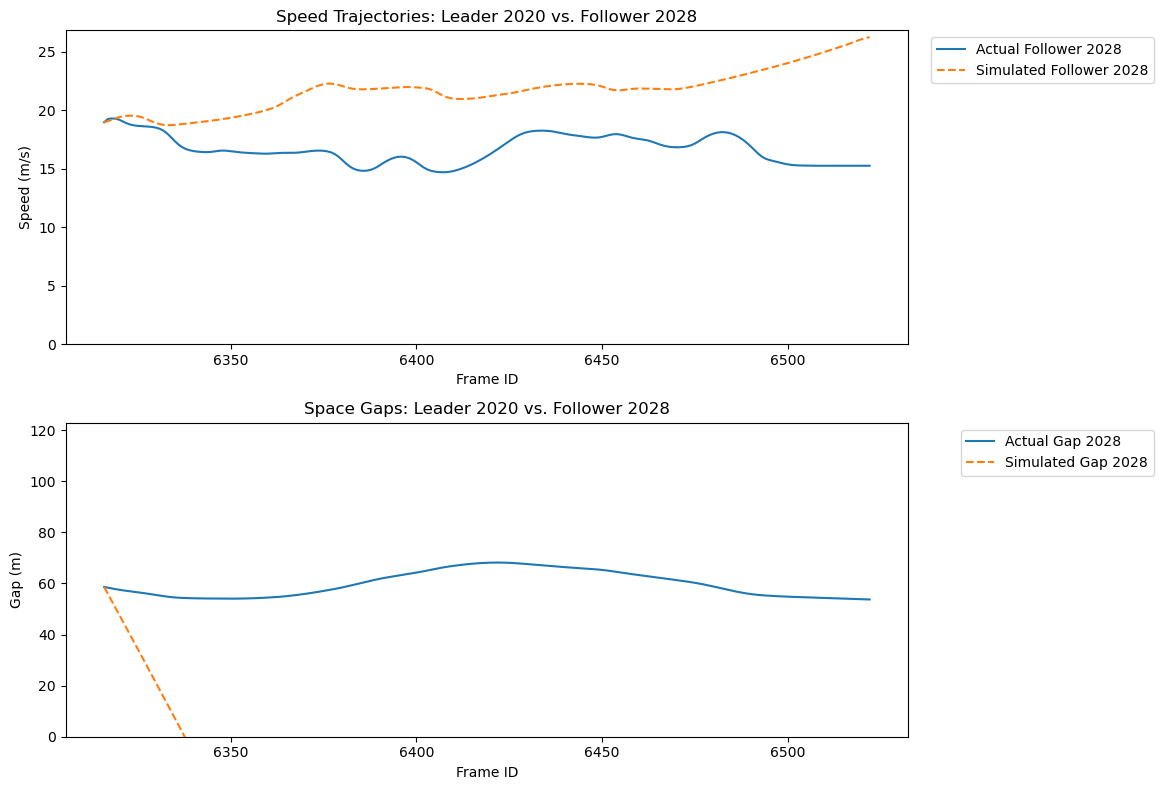

Follower 2794: α = 0.000103, β = 0.000217, τ = 3.000000
Follower 2245: α = 0.000101, β = 0.000107, τ = 3.000000
Follower 2815: α = 0.000103, β = 0.000145, τ = 3.000000
Follower 2084: α = 0.000103, β = 0.000240, τ = 3.000000
Follower 2793: α = 0.000101, β = 0.000111, τ = 3.000000
Follower 2137: α = 0.000100, β = 0.000132, τ = 3.000000
Follower 1930: α = 0.000102, β = 0.000229, τ = 3.000000
Follower 2028: α = 0.000102, β = 0.000256, τ = 3.000000


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

file_path = 'D:/ASU Academics/Traffic Flow Theroy/MP-1/Reconstructed NGSIM I80-1 data/Data/DATA (NO MOTORCYCLES).txt'

columns = [
    "Vehicle ID",
    "Frame ID",
    "Lane ID",
    "LocalY",
    "Mean Speed",
    "Mean Acceleration",
    "Vehicle Length",
    "Vehicle Class ID",
    "Follower ID",
    "Leader ID"
]

def valid_car_following_pairs(df, min_frames):
  # Filter out rows where no follower exists
  df_following = df[(df["Follower ID"] != -1) & (df["Mean Speed"]>=15)]

  # Group by (Leader ID, Follower ID) and count frames
  valid_pairs = (
      df_following.groupby(["Leader ID", "Follower ID"])
      .filter(lambda x: len(x) >= min_frames)
      .groupby(["Leader ID", "Follower ID"])
      .size()
      .reset_index()
      .rename(columns={0: "Frame Count"})
      .sort_values(by="Frame Count", ascending=False)
      .iloc[:15, :2]  # Select top 5 pairs with the longest following duration
      .values.tolist()[0:15]
  )
  return valid_pairs

df = pd.read_csv(file_path, sep='\t', header=None, names=columns)

# Parameter search settings
num_iterations = 1000  # Number of times to search for each pair
error_bound = 50  # Stop early if loss is below this threshold

# Storage for best calibrated parameters
calibrated_params = {}

frame_rate = 10  # Assuming 10 frames per second
min_frames = 20 * frame_rate  # Minimum number of frames to be considered valid

valid_pairs = valid_car_following_pairs(df, min_frames)

def cth_rv_ode(t, y, alpha, beta, tau, leader_speed_interp):
    """ ODE system for CTH-RV model """ # This is not correct!
    s, delta_v = y  # y[0] = s (space gap), y[1] = delta_v (relative velocity)
    leader_speed = leader_speed_interp(t)
    follower_speed = leader_speed - delta_v
    ds_dt = delta_v
    dv_dt = alpha * (s - tau * follower_speed) + beta * delta_v
    return [ds_dt, dv_dt]

def interpolate_leader_speed(leader_data):
    """ Create interpolation function for leader speed """
    return interp1d(leader_data["Frame ID"], leader_data["Mean Speed"], fill_value="extrapolate")


def search_parameters(leader_data, follower_data, num_iterations=100, error_bound=1e-3):
    """
    Searches for optimal parameters (alpha, beta, tau) for the CTH-RV model.
    """
    best_loss = float("inf")
    best_params = None

    for _ in range(num_iterations):
        alpha = np.random.uniform(0.0001, 0.001)
        beta = np.random.uniform(0.0001, 0.001)
        tau = 3.0 #np.random.uniform(0.5, 3.0)  # Seconds
        params = [alpha, beta, tau]

        loss = compute_loss(params, leader_data, follower_data)

        if loss < best_loss:
            best_loss = loss
            best_params = params

        # Stop early if loss is below the threshold
        if loss < error_bound:
            break
    if best_params is None:
      print(f"best_params is none: {loss}")
    return best_params, best_loss

def compute_loss(params, leader_data, follower_data):
    """ Compute sum of squared errors (SSE) between actual and simulated values """
    alpha, beta, tau = params

    # Interpolate leader speed
    leader_speed_interp = interpolate_leader_speed(leader_data)

    # Merge data by Frame ID
    merged = pd.merge(follower_data, leader_data, on="Frame ID", suffixes=("_follower", "_leader"))
    merged["Space Gap"] = merged["LocalY_leader"] - merged["LocalY_follower"]
    merged["Relative Velocity"] = merged["Mean Speed_leader"] - merged["Mean Speed_follower"]

    t_span = [merged["Frame ID"].min(), merged["Frame ID"].max()] # Intergration domain
    y0 = [merged["Space Gap"].iloc[0], merged["Relative Velocity"].iloc[0]] # Initial conditions

    # Solve IVP
    sol = solve_ivp(cth_rv_ode, t_span, y0, t_eval=merged["Frame ID"], args=(alpha, beta, tau, leader_speed_interp))

    # Interpolate simulated values to match actual timestamps
    simulated_space_gap_interp = interp1d(sol.t, sol.y[0], fill_value="extrapolate")
    simulated_follower_speed_interp = interp1d(sol.t, leader_speed_interp(sol.t) - sol.y[1], fill_value="extrapolate")

    simulated_space_gap = simulated_space_gap_interp(merged["Frame ID"])
    simulated_follower_speed = simulated_follower_speed_interp(merged["Frame ID"])

    actual_space_gap = merged["Space Gap"].values
    actual_follower_speed = merged["Mean Speed_follower"].values

    # Compute SSE loss
    loss = np.sum((actual_space_gap - simulated_space_gap) ** 2) + np.sum((actual_follower_speed - simulated_follower_speed) ** 2)
    #print(f"Loss: {loss}\nSol is: {sol}")

    return loss


for leader_id, follower_id in valid_pairs:
    # Create a new figure for each (leader, follower) pair
    plt.figure(figsize=(12, 8))

    # Extract leader and follower data
    leader_data = df[df["Vehicle ID"] == leader_id]
    follower_data = df[df["Vehicle ID"] == follower_id]

    best_params, best_loss = search_parameters(leader_data, follower_data, num_iterations, error_bound)

    # Store best parameters for this follower
    calibrated_params[follower_id] = best_params
    alpha_opt, beta_opt, tau_opt = best_params

    # Solve IVP with optimized parameters
    leader_speed_interp = interpolate_leader_speed(leader_data)
    merged = pd.merge(follower_data, leader_data, on="Frame ID", suffixes=("_follower", "_leader"))

    merged["Space Gap"] = merged["LocalY_leader"] - merged["LocalY_follower"]
    merged["Relative Velocity"] = merged["Mean Speed_leader"] - merged["Mean Speed_follower"]

    t_span = [merged["Frame ID"].min(), merged["Frame ID"].max()]
    y0 = [merged["Space Gap"].iloc[0], merged["Relative Velocity"].iloc[0]]
    sol = solve_ivp(cth_rv_ode, t_span, y0, t_eval=merged["Frame ID"], args=(alpha_opt, beta_opt, tau_opt, leader_speed_interp))

    # Interpolate simulated results
    simulated_space_gap_interp = interp1d(sol.t, sol.y[0], fill_value="extrapolate")
    simulated_follower_speed_interp = interp1d(sol.t, leader_speed_interp(sol.t) - sol.y[1], fill_value="extrapolate")

    simulated_space_gap = simulated_space_gap_interp(merged["Frame ID"])
    simulated_follower_speed = simulated_follower_speed_interp(merged["Frame ID"])

    # Speed Trajectories
    plt.subplot(2, 1, 1)
    plt.plot(merged["Frame ID"], merged["Mean Speed_follower"], label=f"Actual Follower {follower_id}")
    plt.plot(merged["Frame ID"], simulated_follower_speed, label=f"Simulated Follower {follower_id}", linestyle="dashed")
    plt.title(f"Speed Trajectories: Leader {leader_id} vs. Follower {follower_id}")
    plt.xlabel("Frame ID")
    plt.ylabel("Speed (m/s)")
    plt.legend(loc="upper right", bbox_to_anchor=(1.30, 1))
    plt.ylim(0, None)

    # Space Gaps
    plt.subplot(2, 1, 2)
    plt.plot(merged["Frame ID"], merged["Space Gap"], label=f"Actual Gap {follower_id}")
    plt.plot(merged["Frame ID"], simulated_space_gap, label=f"Simulated Gap {follower_id}", linestyle="dashed")
    plt.title(f"Space Gaps: Leader {leader_id} vs. Follower {follower_id}")
    plt.xlabel("Frame ID")
    plt.ylabel("Gap (m)")
    plt.legend(loc="upper right", bbox_to_anchor=(1.30, 1))
    plt.ylim(0, None)

    plt.tight_layout()
    plt.show()  # Show the plot for each pair separately

# Print best calibrated parameters
for follower, params in calibrated_params.items():
    print(f"Follower {follower}: α = {params[0]:.6f}, β = {params[1]:.6f}, τ = {params[2]:.6f}")
